In [31]:
# 对比 DL-Clip \ DL-Oline \ traditional PPO (RL)
# system : inverted pendulum

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pickle

from systems_and_functions.control_affine_system import ControlAffineSystem
from systems_and_functions.cart_pole_system import CartPole
from systems_and_functions.inverted_pendulum_system import InvertedPendulum

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
class PolicyNet(nn.Module):
    def __init__(
        self, 
        n_states: int = 2, 
        n_hiddens: int = 16,
        n_actions: int = 1, 
        action_bound: float = 5.0
    ):
        super(PolicyNet, self).__init__()
        # 环境可以接受的动作最大值
        self.action_bound = action_bound
        self.n_actions = n_actions
        # 只包含一个隐含层
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_actions + 1)

    # 前向传播
    def forward(self, x):
        x = x.t()
        x = self.fc1(x)  # [b,n_states]-->[b,n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # [b,n_hiddens]-->[b,n_actions]]
        return x
    
    def Controller(self, x):
        u = self.forward(x).t()[:self.n_actions]
        return u

class LyapunovNet(nn.Module):
    def __init__(
        self,
        n_states:int = 4, 
        n_hiddens:int = 128
    ):
        super(LyapunovNet, self).__init__()
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, 2)

    def forward(self, x):
        s = self.fc1(x)  # -->[b, n_hiddens]
        s = torch.tanh(s)
        s = self.fc2(s)  # -->[b, n_hiddens]
        s = torch.tanh(s)
        V = self.fc3(s)  # -->[b, 1]
        return V
    
    def V(self, x):
        return self.forward(x)[:,0]

    def V_with_JV(self, x):
        x = x.clone().detach().requires_grad_(True)
        V = self.forward(x)
        JV = torch.autograd.grad(V, x)
        return V, JV

class DFunctionNet(nn.Module):
    def __init__(
        self,
        n_states:int = 4, 
        n_hiddens: int = 128, 
        n_actions: int = 2
    ):
        super(DFunctionNet, self).__init__()
        self.fc1 = nn.Linear(n_states + n_actions, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, 2)

    # 前向传播
    def forward(self, x, a):
        # 拼接状态和动作
        cat = torch.cat([x, a], dim=1)  # [b, n_states + n_actions]
        x = self.fc1(cat)  # -->[b, n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # -->[b, n_hiddens]
        x = F.relu(x)
        x = self.fc3(x)  # -->[b, 1]
        return x

    def D(self, x, a):
        return self.forward(x, a)[:,0]

In [33]:
# D-learning 类，包含了D-learning中的各种功能函数 
class DlearningProcess:
    def __init__(
        self, 
        system: ControlAffineSystem,
        actor_bound: float = 5.0,
        n_hiddens_policy: int = 16,
        n_hiddens_lyapunov: int = 128,
        n_hiddens_dfunction: int = 128,
        actor_lr: float = 0.01,
        lyapunov_lr: float = 0.01,
        dfunction_lr: float = 0.01,
        sigma: float = 0.5,
        tau: float = 0.1,
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    ):
        # 属性分配
        self.system = system # 动力学系统
        self.sigma = sigma # 噪声标准差
        self.tau = tau # 软更新权重
        self.n_states = self.system.state_dims()
        self.n_actions = self.system.control_dims()
        self.device = device
        # 训练网络
        self.actor = PolicyNet(self.system.state_dims(), n_hiddens_policy, self.system.control_dims(), actor_bound).to(device)
        self.lyapunov = LyapunovNet(self.system.state_dims(), n_hiddens_lyapunov).to(device)
        self.dfunction = DFunctionNet(self.system.state_dims(), n_hiddens_dfunction, self.system.control_dims()).to(device)
        # 训练网络的优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.lyapunov_optimizer = torch.optim.Adam(self.lyapunov.parameters(), lr=lyapunov_lr)
        self.dfunction_optimizer = torch.optim.Adam(self.dfunction.parameters(), lr=dfunction_lr)

        # DONE: 初始化神经网络控制器


    def initialize_policy_net(
            self,
            x_train_lim: int = 10,
            x_test_lim: int = 13,
            sample_num: int = 1000,
            iteration: int = 2*10**4,
            lr: float = 1e-4
    ):
        """
        用神经网络拟合专家策略（线性静态状态反馈）
        """
        print('---------------------Initializing Policy------------------------')

        # x = torch.linspace(-x_train_lim, x_train_lim, sample_num, dtype=torch.float)
        # train_data = torch.stack([x] * self.system.state_dims(), dim = 1).to(self.device)

        random_data = [-x_train_lim + torch.rand(400)*2*x_train_lim for _ in range(self.system.state_dims())]
        train_data = torch.stack(random_data, dim=1).to(self.device)
        K = torch.tensor(-self.system.K)
        zero_column = torch.zeros(1, 2)
        K_extended = torch.vstack((K, zero_column)).t().to(self.device)
        labels = train_data @ K_extended
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.SGD(self.actor.parameters(), lr = lr)
        for i in range(iteration):
            optimizer.zero_grad()
            y_train = self.actor(train_data.t())
            loss = loss_fn(y_train, labels)
            # if i % 10000 == 0:
            #     print(f'times {i} - lr {lr} -  loss: {loss.item()}')
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))
            loss.backward()
            optimizer.step()
    
    
    def sample_training_data(
        #  沿轨迹采样 + 均匀分布采样 
        self,
        sample_trajectory_number: int = 10,
        sample_number_per_trajectory: int = 500,
        sample_radius: int = 15,
        sample_number_in_radius: int = 0,
        invariant_sample: bool = True,
        sample_plot: bool = True,
        the_controller = None, # 指定控制器，默认为ControlAffineSystem自带控制器
        title = "Samples"
    )->torch.Tensor:
        """
        sample training data
        data content: x_i, x_dot_i, controller_params
        sample strategy: data set is composed of two parts: 
            samples from trajectory;
            samples from random state;
            (if invariant_sample is true, random state point is Unchanging) 
        """
        sample_from_trajectory = torch.zeros(sample_trajectory_number*sample_number_per_trajectory,2,2,1).to(self.device)
        sample_from_radius = torch.zeros(sample_number_in_radius,2,2,1).to(self.device)
        theta = np.linspace(0, 2*np.pi, sample_trajectory_number + 1)
        
        # sample in trajectory
        for i in range(0, sample_trajectory_number):
            x_0_traj = torch.tensor([[sample_radius*np.cos(theta[i])],[sample_radius*np.sin(theta[i])]],dtype=torch.float).to(self.device)
            simulate_rk4 = self.system.simulate_rk4(x_0_traj,sample_number_per_trajectory,1,the_controller)
            x = simulate_rk4[:,0].unsqueeze(1)
            x_dot = simulate_rk4[:,1].unsqueeze(1)
            sample_from_trajectory[i*sample_number_per_trajectory:(i+1)*sample_number_per_trajectory] = torch.cat((x, x + x_dot*self.system.dt), dim=1)

        # sample randomly in radius
        if invariant_sample == True:
            np.random.seed(42)
        theta_ = np.random.uniform(0, 2*np.pi, sample_number_in_radius)
        r_ = np.sqrt(np.random.uniform(0, sample_radius**2, sample_number_in_radius))
        combined_data = zip(theta_, r_)
        i = 0
        for data in combined_data:
            theta__, r__ = data
            x_0_radius = torch.tensor([[r__ * np.cos(theta__)],[r__ * np.sin(theta__)]]).to(self.device)
            one_step_euler = self.system.one_step_euler(x_0_radius,1,the_controller)[1].to(self.device)
            x = one_step_euler[0].unsqueeze(0)
            x_dot = one_step_euler[1].unsqueeze(0)
            sample_from_radius[i] = torch.cat((x, x + x_dot*self.system.dt), dim=0)
            i = i + 1

        sample_data = torch.cat((sample_from_trajectory,sample_from_radius),dim=0).to(self.device)
        return sample_data


    def learn_V_LQF(
        self,
        sample_data,
        plot_lyapuonv: bool = True
    ):
        """
        learn a V(x) by constraining V(x)>=0, V_dot(x)<=0
        """
        print('--------------------------Learning V--------------------------')
        sample_data = sample_data.cpu().detach().numpy()
        P = cp.Variable((self.system.state_dims(), self.system.state_dims()))
        eta = cp.Variable()
        
        constraints = [P.T == P, eta>=0]
        for i in range(sample_data.shape[0]):
            xi = sample_data[i][0]
            xi_dot = (sample_data[i][1]-sample_data[i][0])/self.system.dt
            constraints.append(xi.T@P@xi>=0)
            constraints.append(xi.T@P@xi_dot+xi_dot.T@P@xi<=-eta*np.linalg.norm(xi)**2)

        objective = cp.Minimize(-eta)
        problem = cp.Problem(objective, constraints)
        # 求解优化问题
        problem.solve()
        print("status:",problem.status)
        # print("optimal value",problem.value)
        # 输出解
        print("var eta (eta should be positive):", eta.value)
        print("var P:", P.value)
        self.P = torch.tensor(P.value).float()

        if plot_lyapuonv:
            xlim = 5
            ylim = 5
            print('-----------------------Plotting Lyapunov-----------------------')
            x = np.linspace(-xlim, xlim, 100)
            y = np.linspace(-ylim, ylim, 100)
            X, Y = np.meshgrid(x, y)
            grid = np.stack([X, Y], axis=-1)
            P = self.P
            Z = np.einsum('...i,ij,...j->...', grid, P, grid)

            plt.figure(figsize=(8, 6))
            plt.contourf(X, Y, Z, levels=25, cmap='RdBu')
            plt.colorbar(label='Lyapunov Function')
            plt.xlabel(r"$\mathregular{x_{1}}$")
            plt.ylabel(r"$\mathregular{x_{2}}$")
            plt.title('Lyapunov Function Contour Plot')
            plt.show()


    def V_value_P_batch(self, x: torch.Tensor):
        """
        x:[sample num, value, n dims]
        return [sumple num, value]
        """
        P = self.P.to(self.device)
        xP = torch.matmul(x, P)
        quadratic_form = torch.sum(xP * x, dim=1, keepdim=True)

        return quadratic_form


    def initialize_lyapunov_net(
            self,
            x_train_lim: int = 15,
            x_test_lim: int = 13,
            sample_num: int = 1000,
            iteration: int = 5*10**4,
            lr: float = 1e-3,
            plot_loss: bool = True,
            plot_lyapuonv: bool = True
    ):
        """
        用lyapunov_net拟合二次型lyapunov作为初始化
        """
        print('--------------------Initializing Lyapunov---------------------')
        random_data = [-x_train_lim + torch.rand(sample_num) * 2 * x_train_lim for _ in range(self.system.state_dims())]
        training_data = torch.stack(random_data, dim=1).to(self.device)
        V_value_P = self.V_value_P_batch(training_data)
        labels = torch.cat([V_value_P, torch.zeros(V_value_P.shape[0],1).to(self.device)], dim=1).to(self.device)

        loss_fn = nn.MSELoss()
        # optimizer = self.lyapunov_optimizer
        # optimizer = torch.optim.Adam(self.lyapunov.parameters(), lr = lr)
        optimizer = torch.optim.Adam(self.lyapunov.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
        loss_values = []
        for i in range(iteration):
            optimizer.zero_grad()
            y_train = self.lyapunov(training_data)
            param_squares = [p ** 2 for p in self.lyapunov.parameters()]
            param_sum_square = sum(torch.sum(p) for p in param_squares)
            loss = loss_fn(y_train, labels) + 0.01 * param_sum_square
            loss_values.append(loss.item())
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))
            loss.backward()
            optimizer.step()
        
        if plot_loss:
            plt.figure(figsize=(10, 5))
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Initializing V Loss')
            plt.legend() 
            plt.show()

        if plot_lyapuonv:
            self.plot_contour(5, 5, 'Lyapunov')

    # DONE: learn a NN Lyapunov Candidate using discrete data
    def learn_V_LNN(
        self,
        sample_data,
        iteration: int = 3*10**3,
        plot_loss: bool = True,
        plot_lyapuonv: bool = True,
        lr: float = 1e-4
    ):
        dt = self.system.dt
        print('--------------------------Learning V--------------------------')
        sample_data = sample_data.detach().clone()
        # DONE: using sample_data = sample_data.detach().clone()
        # RuntimeError: Trying to backward through the graph a second time 
        # (or directly access saved tensors after they have already been freed).
        # Saved intermediate values of the graph are freed when you call 
        # .backward() or autograd.grad(). Specify retain_graph=True 
        # if you need to backward through the graph a second time or 
        # if you need to access saved tensors after calling backward

        # sample initialize ([100, 2, 2, 1])
        # dim1: sample index
        # dim2: x  x'
        # dim3: x1 x2
        # dim4: value

        N = sample_data.shape[0]
        s = sample_data[:,0].permute(0, 2, 1).squeeze(1)
        s_ = sample_data[:,1].permute(0, 2, 1).squeeze(1)
        s0 = torch.tensor([[0.],[0.]]).t().to(device)
        optimizer = torch.optim.Adam(self.lyapunov.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
        # self.lyapunov_optimizer
        loss_values = []

        # 扩大 ROA
        data = sample_data[:,0]
        result = []
        for j in range(data.shape[0]):
            row_sum = torch.sum(data[j,:]**2)
            f = torch.sqrt(row_sum)
            result.append(f.item())  # 将结果添加到列表中，使用item()获取标量值
        Circle_Tuning = torch.tensor(result)
        Circle_Tuning = Circle_Tuning.squeeze()

        for i in range(iteration):
            L0 = self.lyapunov.V(s0)
            Ls = self.lyapunov.V(s)
            Ls_ = self.lyapunov.V(s_)
            dL = (Ls_ - Ls) / dt
            SND = torch.sum(F.relu(dL+0.5))
            PD = torch.sum(F.relu(-Ls))

            Ls_squeezed = Ls.squeeze()
            loss = (PD + 1.5 * SND)/N + 1.2* L0.pow(2) + 2.2*((Circle_Tuning-6*Ls_squeezed).pow(2)).mean()
         
        
            loss.backward(retain_graph = True)  # 计算损失的梯度
            with torch.no_grad(): 
                optimizer.step()                # 根据梯度更新模型参数
                optimizer.zero_grad()           # 清除梯度，准备下一个迭代
            loss_values.append(loss.item())
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))

        if plot_loss:
            plt.figure(figsize=(10, 5))
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training V Loss')
            plt.legend() 
            plt.show()
        
        if plot_lyapuonv:
            self.plot_contour()
        print('L0:{}, PD:{}, torch.sum(F.relu(dL)):{}'.format(L0, PD, torch.sum(F.relu(dL)) ))
    
    def plot_contour(
        self,
        xlim = 5,
        ylim = 5,
        select = 'Lyapunov'
    ):
        print('-----------------------Plotting Lyapunov-----------------------')
        x = np.linspace(-xlim, xlim, 100)
        y = np.linspace(-ylim, ylim, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
            # 将X和Y的值合并成一个二维列向量
                xy = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32).to(device)
                # 计算Lyapunov函数值
                if select == 'Dfunction':
                    Z[i, j] = self.dfunction.D(xy,self.actor.Controller(xy.t())).item()
                else:
                    Z[i, j] = self.lyapunov.V(xy).item()

        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=25, cmap='RdBu')
        plt.colorbar(label='Function Value')
        plt.xlabel(r"$\mathregular{x_{1}}$")
        plt.ylabel(r"$\mathregular{x_{2}}$")
        plt.title(select +' Function Contour Plot')
        plt.show()

    def learn_D_DNN(
        self,
        sample_data,
        iteration: int = 10**4,
        plot_loss: bool = True,
        plot_dfunction: bool = True,
        lr: float = 1e-4
    ):
        dt = self.system.dt
        print('--------------------------Learning D--------------------------')
        sample_data = sample_data.detach().clone()
        N = sample_data.shape[0]
        s = sample_data[:,0].permute(0, 2, 1)
        s_ = sample_data[:,1].permute(0, 2, 1)
        s0 = torch.tensor([[0.],[0.]]).to(device)
        a0 = self.actor.Controller(s0)
        Ls = self.lyapunov(s)
        Ls_ = self.lyapunov(s_)
        dL = ((Ls_ - Ls) / dt).squeeze(1)
        print(dL.shape)
        a = self.actor.Controller(s.squeeze(1).t()).t()
        # optimizer = self.dfunction_optimizer
        optimizer = torch.optim.Adam(self.dfunction.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
        loss_values = []
        loss_fn = nn.MSELoss()
        for i in range(iteration):
            D0 = self.dfunction.D(s0.t(), a0)
            DV_ext = self.dfunction(s.squeeze(1),a)
            DV = self.dfunction.D(s.squeeze(1),a)
            param_squares = [p ** 2 for p in self.dfunction.parameters()]
            param_sum_square = sum(torch.sum(p) for p in param_squares)
            loss = torch.sum(loss_fn(dL, DV_ext)) + torch.sum(F.relu(DV)) + D0**2 + 0.01 * param_sum_square
            loss.backward(retain_graph = True)
            with torch.no_grad(): 
                optimizer.step()
                optimizer.zero_grad()
            loss_values.append(loss.item())
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))
        
        if plot_loss:
            plt.figure(figsize=(10, 5))
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training D Loss')
            plt.legend()
            plt.show()
        
        if plot_dfunction:
            self.plot_contour(select='Dfunction')
        print('torch.sum(loss_fn(dL, DV_ext)):{}, torch.sum(F.relu(DV)):{}, D0:{}'.format(torch.sum(loss_fn(dL, DV_ext)),torch.sum(F.relu(DV)),D0))

    def upper_bound_loss(self, output, K0):
        positive_penalty = torch.sum(torch.relu(output + 0.1))
        control_effort_penalty = torch.sum(self.Learned_K**2)
        upper_bound = torch.max(output, dim=0).values
        control_deviation_penalty = torch.sum((self.Learned_K - K0)**2)
        # print('upper_bound:{}, positive_penalty:{}'.format(upper_bound, positive_penalty))
        return upper_bound + positive_penalty + control_effort_penalty*0 + control_deviation_penalty*0
    
    def mean_variance_loss(self,output):
        positive_penalty = torch.sum(torch.relu(output))
        mean = torch.mean(output)
        variance = torch.var(output)
        # print('Mean:{}, Variance:{}'.format(mean, variance))
        return mean + variance*0.1 + positive_penalty*1000

    def upper_bound_mean_variance_loss(self,output,temp):
        """
        """
        positive_penalty = torch.sum(torch.relu(output))
        # upper_bound = torch.max(output, dim=0).values
        upper_bound = torch.max(temp, dim=0).values
        mean = torch.mean(output)
        variance = torch.var(output)
        return upper_bound*100 + mean*10 + variance*0 + positive_penalty*1000

    # TODO: 策略改进
    def policy_improvement(
        self,
        sample_data,
        iteration: int = 10**4,
        plot_loss: bool = True,
        lr: float = 1e-4,
    ):
        print('----------------------Improveing Policy-----------------------')
        sample_data = sample_data.detach().clone()
        N = sample_data.shape[0]
        s = sample_data[:,0].permute(0, 2, 1).squeeze(1)
        optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
        loss_values = []
        

        for i in range(iteration):
            a_new = self.actor.Controller(s.t()).t()
            DV = self.dfunction.D(s.squeeze(1),a_new)
      
            s_squared = torch.pow(s, 2)
            s_sum = torch.sum(s_squared, dim=1, keepdim=True) 
            s_sum = s_sum.squeeze()

            # 检查s_sum中是否有元素为0
            zero_indices = (s_sum == 0)
            # 将为0的元素设置为10^-6
            s_sum[zero_indices] = 1e-6
            
            DV_s = DV / s_sum
        
            param_squares = [p ** 2 for p in self.actor.parameters()]
            param_sum_square = sum(torch.sum(p) for p in param_squares)
            loss = self.upper_bound_mean_variance_loss(DV,DV_s) + 0.01 * param_sum_square
            loss.backward(retain_graph = True)

            with torch.no_grad(): 
                optimizer.step()
                optimizer.zero_grad()
            loss_values.append(loss.item())

            
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))

        if plot_loss:
            plt.figure(figsize=(10, 5))
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Policy Improvement Loss')
            plt.legend()
            plt.show()


    def plot_contour_lyapunov(
        self,
        xlim=5,
        ylim=5,
        lyapunov=None,
        title='Function Contour Plot'
    ):
        print('-----------------------Plotting Lyapunov-----------------------')
        x = np.linspace(-xlim, xlim, 100)
        y = np.linspace(-ylim, ylim, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                xy = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32)  # Assuming device handling elsewhere
                Z[i, j] = lyapunov.V(xy).item()  # Compute Lyapunov function value

        plt.figure(figsize=(8, 6))
        # Plot contour plot
        levels = np.linspace(np.min(Z), np.max(Z), 20)
        plt.contourf(X, Y, Z, levels=levels, cmap='viridis')
        plt.colorbar(label='Function Value')
        plt.xlabel(r"$\mathregular{x_{1}}$")
        plt.ylabel(r"$\mathregular{x_{2}}$")
        plt.title(title)

        # Plot attraction region where V(x, y) <= 0
        plt.contour(X, Y, Z, levels=[0], colors='blue', linestyles='dashed')

        plt.show()

    def plot_phase_portrait_3(
        self, 
        data_sim: torch.Tensor,
        data_sim1: torch.Tensor,
        arrow_on: bool = False,
        title = 'inverted pendulum phase portrait'
    ):
        data_sim = data_sim.cpu().detach().numpy()
        x_sim = data_sim[:, 0, :, :]
        x_dot_sim = data_sim[:, 1, :, :]
        plt.figure()
        
        num = x_sim.shape[0]
        x_value = x_sim[:, 0, 0]
        y_value = x_sim[:, 1, 0]
        plt.figure(figsize=(10, 6))
        plt.scatter(x_value[0], y_value[0], s=30, alpha=0.5, c='blue', marker='o', label='Initial States')
        
        
        if arrow_on:
            interval = 200  # Draw arrows every interval points
            for i in range(0, num, interval):
                x_dot_x = x_dot_sim[i, 0, 0]
                x_dot_y = x_dot_sim[i, 1, 0]
                dx = 2 * x_dot_x / ((x_dot_x ** 2 + x_dot_y ** 2) ** 0.5)
                dy = 2 * x_dot_y / ((x_dot_x ** 2 + x_dot_y ** 2) ** 0.5)
                plt.arrow(x_sim[i, 0, 0], x_sim[i, 1, 0], dx, dy, head_width=3, head_length=4, fc='r', ec='r')
        
        plt.scatter(x_value[num - 1], y_value[num - 1], s=30, alpha=0.8, c='red', marker='*', label='Stable States')

        plt.plot(x_value, y_value, c='c', label='DL-Clip')
        ##########################################################
        data_sim1 = data_sim1.cpu().detach().numpy()
        x_sim1 = data_sim1[:, 0, :, :]
        x_dot_sim1 = data_sim1[:, 1, :, :]
        
        num1 = x_sim1.shape[0]
        x_value1 = x_sim1[:, 0, 0]
        y_value1 = x_sim1[:, 1, 0]
        
        plt.scatter(x_value1[0], y_value1[0], s=30, alpha=0.5, c='blue', marker='o')
        plt.plot(x_value1, y_value1, c='grey',label='DL-Online')
        
        if arrow_on:
            interval = 200  # Draw arrows every interval points
            for i in range(0, num1, interval):
                x_dot_x1 = x_dot_sim1[i, 0, 0]
                x_dot_y1 = x_dot_sim1[i, 1, 0]
                dx1 = 2 * x_dot_x1 / ((x_dot_x1 ** 2 + x_dot_y1 ** 2) ** 0.5)
                dy1 = 2 * x_dot_y1 / ((x_dot_x1 ** 2 + x_dot_y1 ** 2) ** 0.5)
                plt.arrow(x_sim1[i, 0, 0], x_sim1[i, 1, 0], dx1, dy1, head_width=3, head_length=4, fc='r', ec='r')
        
        plt.scatter(x_value1[num1 - 1], y_value1[num1 - 1], s=30, alpha=0.8, c='red', marker='*')

        ax = plt.gca()
        ax.set_aspect(1)
        plt.xlabel(r"$\mathregular{\theta}$")
        plt.ylabel(r"$\mathregular{\dot{\theta}}$")
        plt.xlim(-1, 5)
        plt.title(title)
        plt.legend()
        # plt.show()
        plt.savefig('result/fig2_c.png')


Controller is involved.
----------------------DL-Clip-----------------------
-----------------------Plotting Lyapunov-----------------------


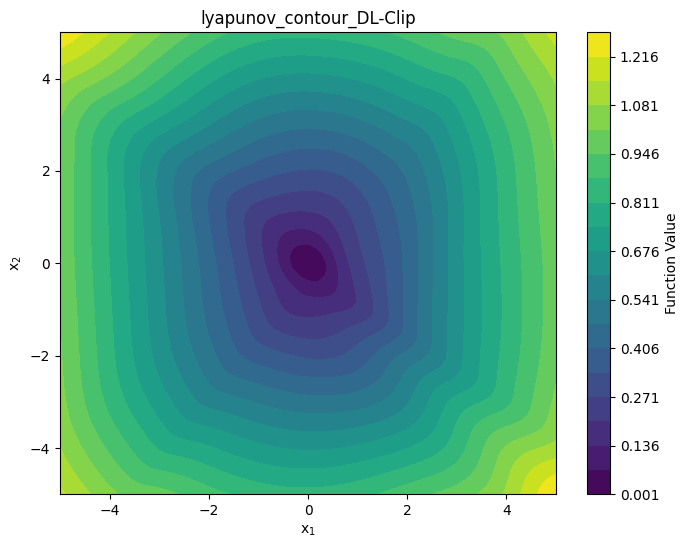

----------------------DL-Online----------------------
-----------------------Plotting Lyapunov-----------------------


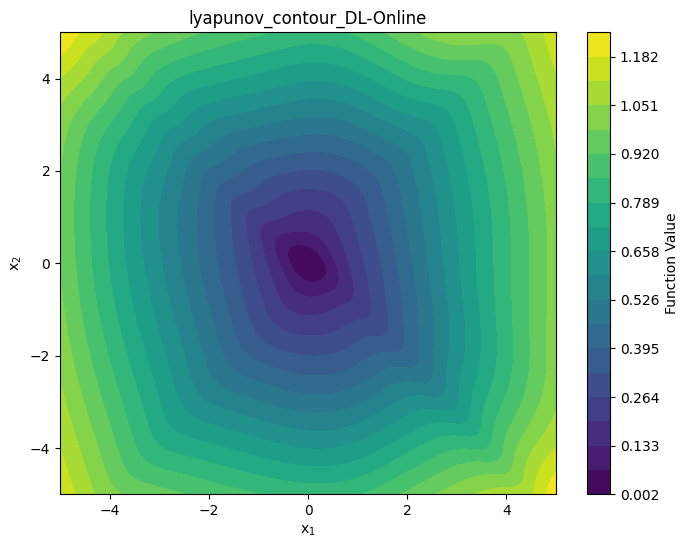

In [34]:
# 初始化动力学模型
params={'m': 2,'L': 1, 'b': 0.1}
controller_params = {'K':np.array([[35, 8]])}

# D learning imitate PPO 控制器
controller_DL_Clip = torch.load('result/controller_DL_Clip.pth')
lyapunov_DL_Clip = torch.load('result/lyapunov_DL_Clip.pth')

controller_DL_Online = torch.load('result/controller_DL_Online.pth')
lyapunov_DL_Online = torch.load('result/lyapunov_DL_Online.pth')

p1 = InvertedPendulum(system_params = params,
                      controller_params = controller_params,
                      dt = 0.01, 
                      controller_period = 0.01)

d1 = DlearningProcess(system=p1,
                      actor_bound=5.0,
                      n_hiddens_policy=16,
                      n_hiddens_lyapunov=16,
                      n_hiddens_dfunction=32,
                      actor_lr=0.001,
                      lyapunov_lr=0.004,
                      dfunction_lr=0.001)

print('----------------------DL-Clip-----------------------')
sim_data = d1.sample_training_data(sample_trajectory_number = 16,
                                sample_number_per_trajectory = 300,
                                sample_radius = 10,
                                sample_number_in_radius = 0,
                                invariant_sample = 1,
                                sample_plot = 1,
                                the_controller = controller_DL_Clip,
                                title = 'Controller_DL-Clip')

d1.plot_contour_lyapunov(lyapunov = lyapunov_DL_Clip,
                        title = 'lyapunov_contour_DL-Clip')


print('----------------------DL-Online----------------------')

sim_data = d1.sample_training_data(sample_trajectory_number = 16,
                                sample_number_per_trajectory = 300,
                                sample_radius = 10,
                                sample_number_in_radius = 0,
                                invariant_sample = 1,
                                sample_plot = 1,
                                the_controller = controller_DL_Online,
                                title = 'Controller_DL-Online')

d1.plot_contour_lyapunov(lyapunov = lyapunov_DL_Online,
                        title = 'lyapunov_contour_DL-Online')



In [35]:
def plot_sampling_lyapunov(
    sample_trajectory_number: int = 10,
    sample_number_per_trajectory: int = 500,
    sample_radius: int = 15,
    sample_number_in_radius: int = 0,
    invariant_sample: bool = True,
    sample_plot: bool = True,
    the_controller=None,
    xlim=5,
    ylim=5,
    lyapunov=None,
    title='Function Contour Plot'
):
    x = np.linspace(-xlim, xlim, 100)
    y = np.linspace(-ylim, ylim, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            xy = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32)
            Z[i, j] = lyapunov.V(xy).item()

    # Plot contour plot on the same figure
    plt.figure(figsize=(8, 6))
    levels = np.linspace(np.min(Z), np.max(Z), 20)
    plt.contourf(X, Y, Z, levels=levels, cmap='viridis')
    plt.colorbar(label='Lyapunov Function Value')
    plt.contour(X, Y, Z, levels=[0], colors='blue', linestyles='dashed')
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$\dot{\theta}$")
    plt.title(title)
    plt.grid(True)

    sample_from_trajectory = torch.zeros(sample_trajectory_number * sample_number_per_trajectory, 2, 2, 1).to(d1.device)
    sample_from_radius = torch.zeros(sample_number_in_radius, 2, 2, 1).to(d1.device)
    theta = np.linspace(0, 2 * np.pi, sample_trajectory_number + 1)

    # sample in trajectory
    for i in range(sample_trajectory_number):
        x_0_traj = torch.tensor([[sample_radius * np.cos(theta[i])], [sample_radius * np.sin(theta[i])]],
                                dtype=torch.float).to(d1.device)
        simulate_rk4 = d1.system.simulate_rk4(x_0_traj, sample_number_per_trajectory, 1, the_controller)
        x = simulate_rk4[:, 0].unsqueeze(1)
        x_dot = simulate_rk4[:, 1].unsqueeze(1)
        sample_from_trajectory[i * sample_number_per_trajectory:(i + 1) * sample_number_per_trajectory] = torch.cat(
            (x, x + x_dot * d1.system.dt), dim=1)

    # sample randomly in radius
    if invariant_sample:
        np.random.seed(42)
    theta_ = np.random.uniform(0, 2 * np.pi, sample_number_in_radius)
    r_ = np.sqrt(np.random.uniform(0, sample_radius ** 2, sample_number_in_radius))
    combined_data = zip(theta_, r_)
    i = 0
    for data in combined_data:
        theta__, r__ = data
        x_0_radius = torch.tensor([[r__ * np.cos(theta__)], [r__ * np.sin(theta__)]]).to(d1.device)
        one_step_euler = d1.system.one_step_euler(x_0_radius, 1, the_controller)[1].to(d1.device)
        x = one_step_euler[0].unsqueeze(0)
        x_dot = one_step_euler[1].unsqueeze(0)
        sample_from_radius[i] = torch.cat((x, x + x_dot * d1.system.dt), dim=0)
        i += 1

    if sample_plot:
        x1_trajectory = sample_from_trajectory[:, 0, 0, :].cpu().detach().numpy()
        x2_trajectory = sample_from_trajectory[:, 0, 1, :].cpu().detach().numpy()
        plt.scatter(x1_trajectory, x2_trajectory, s=10, alpha=0.5, c='white', edgecolors='gray', label='Sample from trajectories')
        for i in range(0, len(x1_trajectory), sample_number_per_trajectory):
            plt.scatter(x1_trajectory[i + 299], x2_trajectory[i + 299], s=30, alpha=0.8, c='red', marker='*',
                        label='Stable States' if i == 0 else '')

        x1_radius = sample_from_radius[:, 0, 0, :].cpu().detach().numpy()
        x2_radius = sample_from_radius[:, 0, 1, :].cpu().detach().numpy()
        plt.scatter(x1_radius, x2_radius, s=10, alpha=0.5, c='g')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()
    plt.savefig('result/fig2_a.png')

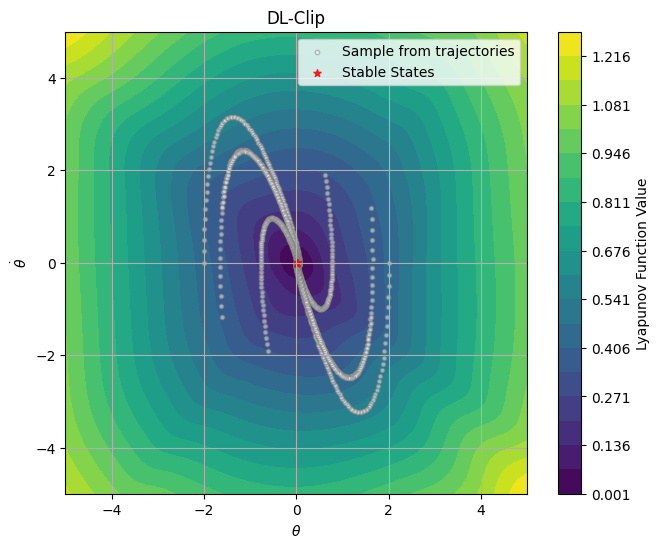

In [36]:
# D-learning online
plot_sampling_lyapunov(sample_trajectory_number = 10,
        sample_number_per_trajectory = 300,
        sample_radius = 2,
        sample_number_in_radius = 0,
        invariant_sample = 1,
        sample_plot = 1,
        the_controller = controller_DL_Clip,
        lyapunov = lyapunov_DL_Clip,
        title = 'DL-Clip')




In [37]:
# LQR
# params={'m': 2,'L': 1, 'b': 0.1}
# controller_params = {'K':np.array([[35, 8]])}

# p1 = InvertedPendulum(system_params = params,
#                       controller_params = controller_params,
#                       dt = 0.01, 
#                       controller_period = 0.01)

# p1.linearize_and_compute_LQR()
# x_initial = torch.tensor([[3],[1]]).to(device)
# step_num = 4000
# sim_data_ = p1.simulate_rk4(x_initial, step_num, 1,)
# p1.convergence_judgment(sim_data_)
# p1.plot_phase_portrait(data_sim = sim_data_,
#                        arrow_on = False,
#                        title = 'System Phase Portrait with initial controller')
stepconverge_LQR = 147  # 跑一下上面注释的代码得到的结果

----------------------Comparison----------------------


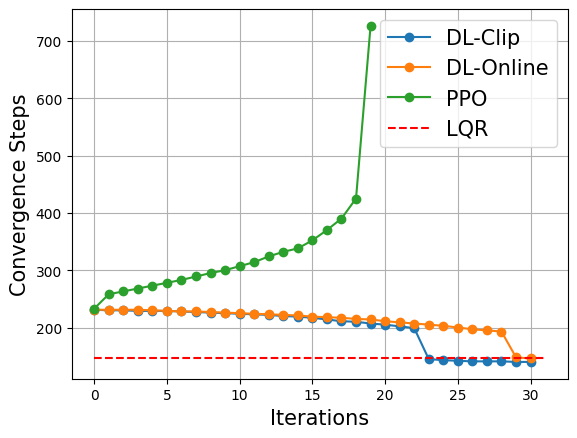

In [38]:
print('----------------------Comparison----------------------')
# 读取保存的 stepconverge_list 文件
with open('result/stepconverge_list_DL_Clip.pk', 'rb') as f:
    stepconverge_list__DL_Clip = pickle.load(f)
stepconverge_list__DL_Clip = stepconverge_list__DL_Clip[:31]
with open('result/stepconverge_list_DL_Online.pk', 'rb') as f:
    stepconverge_list__DL_Online = pickle.load(f)

with open('result/stepconverge_list_PPO.pk', 'rb') as f:
    stepconverge_list_PPO = pickle.load(f)
    
# 绘制 stepconverge 值随迭代次数变化的折线图
plt.figure()
plt.plot(range(0, len(stepconverge_list__DL_Clip)), stepconverge_list__DL_Clip, marker='o',label='DL-Clip')
plt.plot(range(0, len(stepconverge_list__DL_Online)), stepconverge_list__DL_Online, marker='o', label='DL-Online')
plt.plot(range(0, len(stepconverge_list_PPO)), stepconverge_list_PPO, marker='o', label='PPO')
# plt.axhline(y=stepconverge_LQR, color='r', linestyle='--', label= 'LQR')
plt.plot([0, len(stepconverge_list__DL_Clip)], [stepconverge_LQR, stepconverge_LQR], color='r', linestyle='--', label='LQR')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Convergence Steps', fontsize=15)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize ='15')  # Show legend with added line
# plt.show()
plt.savefig('result/fig2_b.png')


-----------------It takes 143 steps to converge.------------------
-----------------It takes 146 steps to converge.------------------


<Figure size 640x480 with 0 Axes>

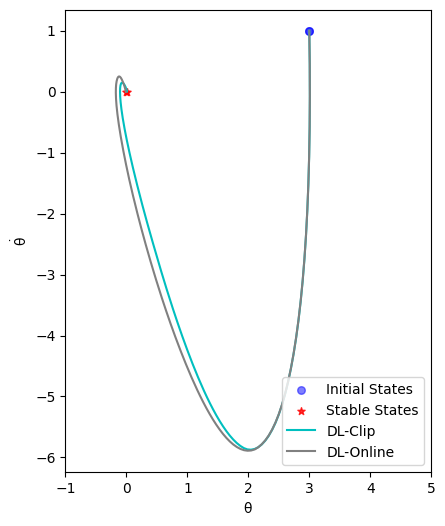

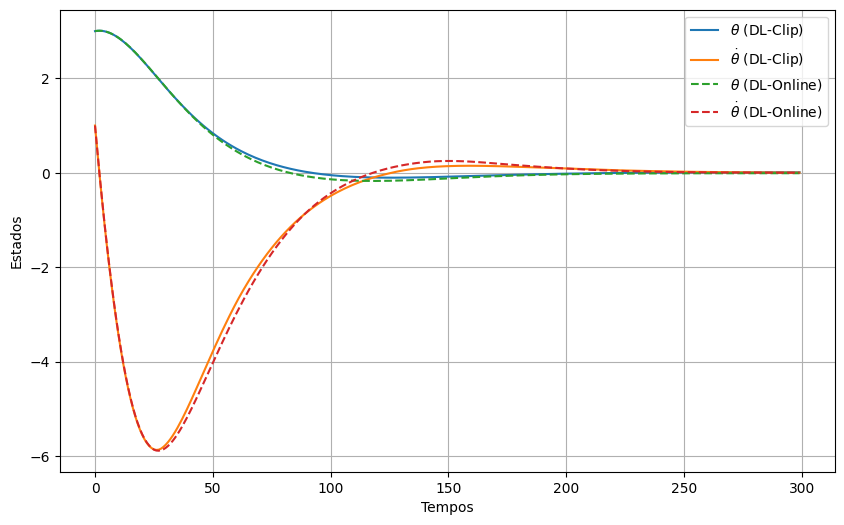

In [39]:
# 以 x_initial 初始点为例 
x_initial = torch.tensor([[3],[1]]).to(device)
step_num = 4000

sim_data_1 = p1.simulate_rk4(x_initial = x_initial, 
                           step_number = step_num,
                           use_controller = 1,
                           the_controller = controller_DL_Clip)
stepconverge_initial1 = p1.convergence_judgment(sim_data_1)

sim_data_2 = p1.simulate_rk4(x_initial = x_initial, 
                           step_number = step_num,
                           use_controller = 1,
                           the_controller = controller_DL_Online)
stepconverge_initial2 = p1.convergence_judgment(sim_data_2)


d1.plot_phase_portrait_3(data_sim = sim_data_1,
                       data_sim1 = sim_data_2,
                       arrow_on = False,
                       title = '')

# DL-PPO
s1 = sim_data_1[:,0].permute(0, 2, 1).squeeze(1)
theta1 = s1[:, 0].detach().numpy() 
theta_dot1 = s1[:, 1].detach().numpy() 

# D-learning online
s2 = sim_data_2[:,0].permute(0, 2, 1).squeeze(1)
theta2 = s2[:, 0].detach().numpy() 
theta_dot2 = s2[:, 1].detach().numpy() 

num = 300
plt.figure(figsize=(10, 6))
plt.plot(range(num), theta1[:num], label=r'$\theta$ (DL-Clip)')
plt.plot(range(num), theta_dot1[:num], label=r'$\dot{\theta}$ (DL-Clip)')

plt.plot(range(num), theta2[:num], linestyle='--', label=r'$\theta$ (DL-Online)')
plt.plot(range(num), theta_dot2[:num], linestyle='--', label=r'$\dot{\theta}$ (DL-Online)')

# plt.title('Variation of Data')
plt.xlabel('Tempos')
plt.ylabel('Estados')
plt.grid(True)  # 添加网格线
plt.legend()  # 添加图例
# plt.show()
plt.savefig('result/fig2_d.png')